# Lab 6.1 Nadine Kanbier 4283724

## Part 1

Q1. Choose one trailer.

In [1]:
import pandas as pd
data = pd.read_csv("trailers.csv")

In [2]:
data.head()

,trailer_title,url,imdb_id,year,rating,votes,genre
0,THE BIG PARADE trailer,https://archive.org/download/TheBigParadeTrail...,15624,1925,7.9,6148.0,Drama|Romance|War
1,ALL QUIET ON THE WESTERN FRONT 1930 trailer,https://archive.org/download/AllQuietOnTheWest...,20629,1930,8.0,56948.0,Drama|War
2,THE OREGON TRAIL trailer,https://archive.org/download/TheOregonTrailTra...,20691,1926,7.2,3353.0,Adventure|Romance|Western
3,FIVE STAR FINAL trailer,https://archive.org/download/FiveStarFinalTrai...,21873,1931,7.2,1790.0,Crime|Drama
4,LITTLE CAESAR trailer,https://archive.org/download/LittleCaesarTrail...,21079,1931,7.3,11958.0,Action|Crime|Drama|Romance


A2. I've chosen Harry Potter and the Sorcerer's Stone (https://archive.org/download/HarryPotterTheSorcerersStoneTrailer1/HarryPotterTheSorcerersStoneTrailer1.mp4)

Q2. How many scenes? Which scenes are missed/counted twice, and why do you think that is?

In [6]:
pip install 'scenedetect'

     |████████████████████████████████| 106 kB 2.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
from scenedetect import VideoManager
from scenedetect import SceneManager

from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import generate_images

def find_scenes(video_path, threshold=30.0):
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(
        ContentDetector(threshold=threshold))
    base_timecode = video_manager.get_base_timecode()
    video_manager.set_downscale_factor()
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager, show_progress=False)    
    return scene_manager.get_scene_list(base_timecode)

In [10]:
filename = 'HarryPotterTheSorcerersStoneTrailer2.mp4'
scene_list = find_scenes(filename, threshold=10)

len(scene_list)

160

A2. 160 is a lot of scenes for one trailer, but after inspecting the trailer I get why the algorithm thinks there are a lot of scenes. They change very quickly and it is hard to know which frame belongs to what scene. 

Q3. Does 10 produce better results? And 50?

In [11]:
scene_list = find_scenes(filename, threshold=10)
print(len(scene_list))

160


In [12]:
scene_list = find_scenes(filename, threshold=50)
print(len(scene_list))

30


A3. The threshold of 50 performs best.

Q4. Does the classifier perform accurately?

In [14]:
import cv2
cap = cv2.VideoCapture(filename)

frames = []
shot_length = []

for start_time, end_time in scene_list:
    duration = end_time - start_time
    frame = (start_time.get_frames() + int(duration.get_frames() / 2))
    cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
    shot_length.append(duration.get_seconds())

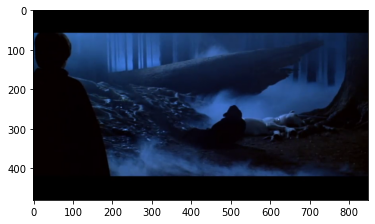

In [44]:
import matplotlib.pyplot as plt

plt.imshow(frames[7]) # print the 7th scene

In [16]:
import os

if not os.path.exists('scenes/'):
    os.mkdir('scenes/')

for i, frame in enumerate(frames):
    cv2.imwrite('scenes/frame_{}.jpg'.format(i), frame)

In [39]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [31]:
from platform import python_version

print(python_version())

3.8.3


In [32]:
model = keras.models.load_model('shot_classifier_python38.h5')

In [40]:
def preprocess_frame(frame, single_batch=False,  color_mode='rgb'):
    frame = cv2.resize(frame, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
    if color_mode == 'grayscale':
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    if single_batch:
        frame = tf.expand_dims(frame, 0)
    return frame

processed_frames = [preprocess_frame(frame) for frame in frames]
processed_frames = np.array(processed_frames)
data = tf.data.Dataset.from_tensor_slices(processed_frames).batch(64)

probabilities = model.predict(data, verbose=1)
labels = ['CS', 'ECS', 'FS', 'LS', 'MS']

image_classes = np.argmax(probabilities, axis=1)
image_labels = [labels[image_class] for image_class in image_classes]
print(image_labels)

1/1 [==============================] - 0s 2ms/step
['FS', 'MS', 'ECS', 'FS', 'CS', 'MS', 'CS', 'FS', 'MS', 'FS', 'ECS', 'FS', 'CS', 'MS', 'MS', 'CS', 'ECS', 'MS', 'MS', 'FS', 'FS', 'CS', 'FS', 'MS', 'MS', 'CS', 'ECS', 'CS', 'ECS', 'FS']


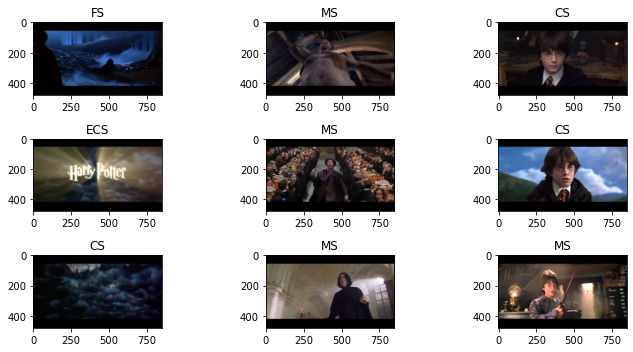

In [41]:
random_indices = np.random.choice(range(len(image_classes)), 
                                  size=9, replace=False)

frames_sample = np.array(frames)[random_indices]
classes_sample = np.array(image_labels)[random_indices]

fig, axes = plt.subplots(nrows = 3, ncols=3, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(frames_sample[i])
    ax.set_title(classes_sample[i])
plt.tight_layout()

In [42]:
print(filename)
df = pd.DataFrame()
df['video'] = [filename for i in range(len(frames))]
df['shot'] = range(len(frames))
df['shot_length'] = shot_length
df['shot_type'] = image_labels

df

HarryPotterTheSorcerersStoneTrailer2.mp4


,video,shot,shot_length,shot_type
0,HarryPotterTheSorcerersStoneTrailer2.mp4,0,7.407400,FS
1,HarryPotterTheSorcerersStoneTrailer2.mp4,1,11.678333,MS
2,HarryPotterTheSorcerersStoneTrailer2.mp4,2,3.236567,ECS
3,HarryPotterTheSorcerersStoneTrailer2.mp4,3,38.071367,FS
4,HarryPotterTheSorcerersStoneTrailer2.mp4,4,9.275933,CS
5,HarryPotterTheSorcerersStoneTrailer2.mp4,5,1.868533,MS
6,HarryPotterTheSorcerersStoneTrailer2.mp4,6,3.636967,CS
7,HarryPotterTheSorcerersStoneTrailer2.mp4,7,4.204200,FS
8,HarryPotterTheSorcerersStoneTrailer2.mp4,8,11.011000,MS
9,HarryPotterTheSorcerersStoneTrailer2.mp4,9,2.502500,FS


Q5. Python function

In [45]:
def process_video(filename, model = model, labels = labels):
    # create list of scenes
    scene_list = find_scenes(filename, threshold=30)
    
    # get frame info
    cap = cv2.VideoCapture(filename)
    
    frames = []
    shot_length = []

    for start_time, end_time in scene_list:
        duration = end_time - start_time
        frame = (start_time.get_frames() + int(duration.get_frames() / 2))
        cap.set(cv2.CAP_PROP_POS_FRAMES,frame)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        shot_length.append(duration.get_seconds())
    
    # preprocess frames
    processed_frames = [preprocess_frame(frame) for frame in frames]
    processed_frames = np.array(processed_frames)
    data = tf.data.Dataset.from_tensor_slices(processed_frames).batch(64)
    
    # predict labels
    probabilities = model.predict(data, verbose=1)
    image_classes = np.argmax(probabilities, axis=1)
    image_labels = [labels[image_class] for image_class in image_classes]
    
    # create dataframe
    df = pd.DataFrame()
    df['video'] = [filename for i in range(len(frames))]
    df['shot'] = range(len(frames))
    df['shot_length'] = shot_length
    df['shot_type'] = image_labels
    
    return df

## Part 2

Q1. Make a subset of the dataframe

In [56]:
trailers = pd.read_csv('trailers.csv')
trailers.head()

,trailer_title,url,imdb_id,year,rating,votes,genre
0,THE BIG PARADE trailer,https://archive.org/download/TheBigParadeTrail...,15624,1925,7.9,6148.0,Drama|Romance|War
1,ALL QUIET ON THE WESTERN FRONT 1930 trailer,https://archive.org/download/AllQuietOnTheWest...,20629,1930,8.0,56948.0,Drama|War
2,THE OREGON TRAIL trailer,https://archive.org/download/TheOregonTrailTra...,20691,1926,7.2,3353.0,Adventure|Romance|Western
3,FIVE STAR FINAL trailer,https://archive.org/download/FiveStarFinalTrai...,21873,1931,7.2,1790.0,Crime|Drama
4,LITTLE CAESAR trailer,https://archive.org/download/LittleCaesarTrail...,21079,1931,7.3,11958.0,Action|Crime|Drama|Romance


In [48]:
import random
n = random.randint(0,9)

In [57]:
trailers_2040 = trailers[(trailers.year > 1920) & (trailers.year < 1940)].sample(n)
trailers_6080 = trailers[(trailers.year > 1960) & (trailers.year < 1980)].sample(n)
trailers_0020= trailers[trailers.year > 2000].sample(n)

Q2. Download the videos

In [62]:
!pip install wget
!pip install tqdm

In [68]:
import wget
from tqdm.notebook import tqdm

def dl_sample(df, folder):
    if not os.path.exists(folder):
        os.mkdir(folder)
    
    video_paths = []
    for video in df.itertuples():
        video_url = video.url
        output_path = folder + video.trailer_title + '.mp4'
        filename = wget.download(video_url, out=output_path)
        video_paths.append(output_path)
        
    return video_paths

In [69]:
trailer1920 = dl_sample(trailers_2040, 'vid_1920/')
trailer1960 = dl_sample(trailers_6080, 'vid_1960/')
trailer2000 = dl_sample(trailers_0020, 'vid_2000/')

In [70]:
def analyze_trailers(videos):
    dfs = []
    for vid in videos:
        dfs.append(process_video(vid))
    return pd.concat(dfs)
    

Q3. Process the videos

In [71]:
shots1920 = analyze_trailers(trailer1920)

1/1 [==============================] - 0s 780us/step


In [72]:
shots1960 = analyze_trailers(trailer1960)
shots2000 = analyze_trailers(trailer2000)

1/1 [==============================] - 0s 931us/step


Q4. Get the statistics

In [73]:
def get_statistics(df):
    print('mean shot length:', df.shot.mean())
    print('shot length stdev:', df.shot.std())
    display(df.shot_type.value_counts() / df.shot_type.value_counts().sum())
    
get_statistics(shots1920)
get_statistics(shots1960)
get_statistics(shots2000)

mean shot length: 9.764705882352942
shot length stdev: 7.895053518593618


MS     0.323529
FS     0.279412
CS     0.250000
ECS    0.147059
Name: shot_type, dtype: float64

mean shot length: 35.67755102040816
shot length stdev: 30.005158472528112


FS     0.265306
MS     0.236735
CS     0.228571
ECS    0.195918
LS     0.073469
Name: shot_type, dtype: float64

mean shot length: 56.99772209567198
shot length stdev: 40.86275608646526


FS     0.296128
MS     0.250569
ECS    0.214123
CS     0.205011
LS     0.034169
Name: shot_type, dtype: float64